<a href="https://colab.research.google.com/github/Beh-noush/General-Python/blob/main/MLP_and_conv_deepnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References for this code: https://github.com/Cours-EDUlib/IVADO-DL101/blob/master/tutorials/Day3_CNN_solutions.ipynb, https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and https://github.com/likarajo/ant_bees/blob/main/ant_bees.ipynb.

#PART 1: MLP on MNIST

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import dataloader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
def plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test):
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  plt.plot(acc_list_train,'blue',label = 'train')
  plt.plot(acc_list_test,'orange',label = 'test')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.grid()
  plt.legend()
  plt.subplot(122)
  plt.plot(loss_list_train,'blue',label = 'train')
  plt.plot(loss_list_test,'orange',label = 'test')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.grid()
  plt.legend()  

In [4]:
transform = torchvision.transforms.ToTensor()

In [ ]:
mnist_dataset_train = torchvision.datasets.MNIST('mnist_data' ,train = True, transform = transform, download= True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
train_data, valid_data = torch.utils.data.random_split(mnist_dataset_train,[40000,20000])

In [ ]:
type(mnist_dataset_train)

torchvision.datasets.mnist.MNIST

In [ ]:
batch_size = 50
mnist_train_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size= batch_size, shuffle= True)
num_batches_train = len(mnist_train_loader)
mnist_valid_loader = torch.utils.data.DataLoader(valid_data, batch_size= batch_size, shuffle= True)
num_batches_valid = len(mnist_valid_loader)

In [5]:
is_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if is_gpu else 'cpu')
device

device(type='cpu')

In [6]:
def train_nn(nn_model, loss, optimizer, train_loader, valid_loader, epochs, fully_connected = False):
  acc_list_train = []
  loss_list_train = []
  acc_list_test = []
  loss_list_test = []
  num_batches_train=len(train_loader)
  # print(num_batches_train)
  num_batches_valid=len(valid_loader)
  # print(num_batches_valid)
  for e in tqdm(range(epochs)):
    model_loss = 0
    model_acc = 0
    nn_model.train()
    
    for (data,label) in train_loader:
      data = data.to(device)
      if fully_connected:
        data = data.view(-1,28*28) #Note that 28 is only valid for mnist, not for example for CIFAR.
      label = label.to(device)
      nn_output = nn_model(data)
      _, predict = torch.max(nn_output, axis =1)
      batch_loss = loss(nn_output, label)
      model_loss += batch_loss/num_batches_train
      batch_acc = torch.mean((predict == label).float())/num_batches_train
      model_acc += batch_acc

      batch_loss.backward()
      # if e==1:
        # print(nn_model.out.weight.grad) 
      optimizer.step()
      optimizer.zero_grad()

    acc_list_train.append(model_acc)
    loss_list_train.append(model_loss)
    valid_loss = 0
    valid_acc = 0
    nn_model.eval()

    for (data,label) in valid_loader:
      data = data.to(device)
      if fully_connected:
        data = data.view(-1,28*28)
      label = label.to(device)
      with torch.no_grad():
        valid_out = nn_model(data)
        batch_loss = loss(valid_out, label)
        valid_loss += batch_loss/num_batches_valid
        _,valid_pred = torch.max(valid_out,axis = 1)
        batch_acc = torch.mean((valid_pred == label).float())
        valid_acc += batch_acc/num_batches_valid

    acc_list_test.append(valid_acc)
    loss_list_test.append(valid_loss)
  return (acc_list_train, loss_list_train, acc_list_test, loss_list_test)

In [ ]:
#A mlp with three hidden layers of sizes 1000, 1500, 800
#Also, I am trying Kaiming(He) initialization.
class MLP(nn.Module):
  def __init__(self, hidden_1, hidden_2):#, hidden_3):
    super(MLP,self).__init__()

    self.hidden_1, self.hidden_2 = hidden_1, hidden_2
    #self.normalized_input = nn.BatchNorm1d(28*28)
    self.fc1 = nn.Linear(784, self.hidden_1)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
    nn.init.kaiming_normal_(self.fc2.weight)

 #   self.fc3 = nn.Linear(self.hidden_2, self.hidden_3)
    self.out = nn.Linear(self.hidden_2, 10)
    nn.init.kaiming_normal_(self.out.weight)

  def forward(self,x):
    #x = self.normalized_input(x)
    activ_1 = F.relu(self.fc1(x))
    activ_2 = F.relu(self.fc2(activ_1))
   # activ_3 = F.relu(self.fc3(activ_2))
    output = F.softmax(self.out(activ_2))
    #output = self.out(activ_2)
    return output

In [ ]:
test_model = MLP(512,128)

In [ ]:
torch.std(test_model.out.weight)

tensor(0.1274, grad_fn=<StdBackward0>)

In [ ]:
print(f"number of biases in layer 1 is {test_model.fc1.bias.shape}")

number of biases in layer 1 is torch.Size([512])


In [ ]:
(2/512)**(.5)

0.0625

In [ ]:
#A small experiment with zero initialization for weights. We see that the NN still learns, just much slower. But, when I initialize weights to .1 
#the neural net learns almost nothing over these ten epochs. Maybe because .1 is too big, but how a big weight initialization is problematic with 
#ReLU non-linearity? If I had tanh, I could understand that .1 could be too big, but why ReLU?
test_model.out.weight.data.fill_(0.)
test_model.fc2.weight.data.fill_(0.)
test_model.fc1.weight.data.fill_(0.)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
list(test_model.parameters())

In [ ]:
epochs = 10
mlp_model = test_model.to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(mlp_model, loss, optimizer, mnist_train_loader, mnist_valid_loader, epochs, fully_connected = True)

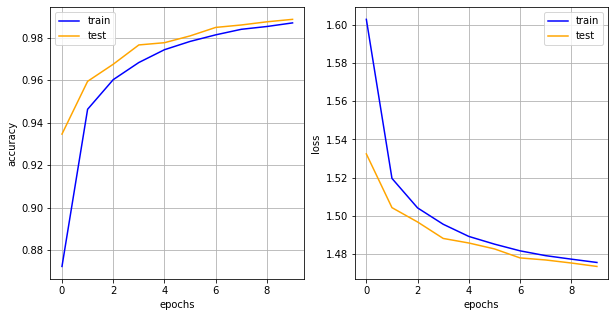

In [ ]:
#Plot the results for MLP with uniform weights and bias initialization!
plot_results([train_acc.cpu() for train_acc in acc_list_train], [test_acc.cpu() for test_acc in acc_list_test], [loss_train.detach().cpu() for loss_train in loss_list_train], [loss_test.detach().cpu() for loss_test in loss_list_test])

In [ ]:
mlp_model.out.weight

In [ ]:
mlp_model.fc1.weight

Parameter containing:
tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]],
       requires_grad=True)

In [ ]:
mlp_model.out.bias.grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
epochs = 5
mlp_model = MLP(512,128)
mlp_model = mlp_model.to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(mlp_model, loss, optimizer, mnist_train_loader, mnist_valid_loader, epochs, fully_connected = True)

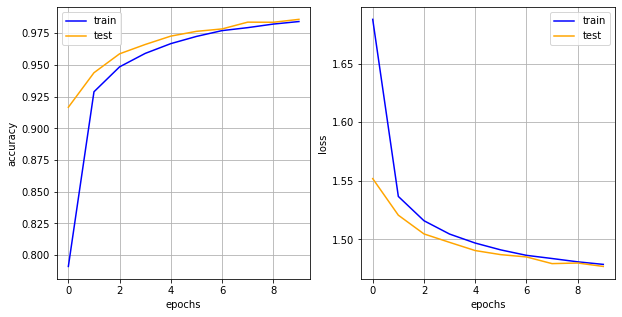

In [ ]:
#Plot the results for MLP!
plot_results(acc_list_train, acc_list_test, [loss_train.detach() for loss_train in loss_list_train], [loss_test.detach() for loss_test in loss_list_test])

In [ ]:
mlp_model.fc1.weight

Parameter containing:
tensor([[-0.0225, -0.0319,  0.0162,  ..., -0.0091,  0.0260, -0.0126],
        [-0.0173, -0.0143,  0.0152,  ...,  0.0011, -0.0010,  0.0297],
        [-0.0010, -0.0279, -0.0003,  ...,  0.0287, -0.0153, -0.0140],
        ...,
        [-0.0268,  0.0009,  0.0221,  ..., -0.0322, -0.0017,  0.0242],
        [ 0.0356, -0.0205, -0.0120,  ...,  0.0314,  0.0220,  0.0133],
        [ 0.0169,  0.0288,  0.0350,  ...,  0.0278,  0.0079,  0.0128]],
       requires_grad=True)

#PART 2: CNN on MNIST

In [ ]:
#LeNet5
class Lenet5(nn.Module):
  def __init__(self, kernel_size, pool_size):
    super(Lenet5, self).__init__()
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.layer1 = nn.Sequential(nn.Conv2d(1,16,5,padding='same'), nn.ReLU(), nn.AvgPool2d(2))
    self.layer2 = nn.Sequential(nn.Conv2d(16,32,5,padding='same'), nn.ReLU(), nn.AvgPool2d(2))
    self.outlayer = nn.Linear(7*7*32, 10)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,7*7*32)
    x = self.outlayer(x)
    output = nn.functional.softmax(x)
    return output

In [ ]:
epochs = 10
lenet_model = Lenet5(3,2)
lenet_model = lenet_model.to(device)
optimizer = optim.SGD(lenet_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(lenet_model, loss,optimizer, mnist_train_loader, mnist_valid_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
100%|██████████| 10/10 [01:16<00:00,  7.68s/it]


In [ ]:
print(lenet_model)

print("\n\n# Parameters: ", sum([param.nelement() for param in lenet_model.parameters()]))

Lenet5(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (outlayer): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  28938


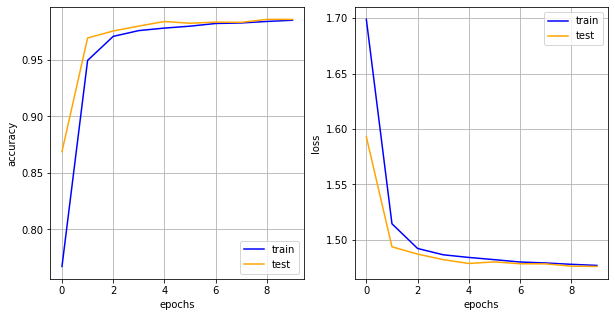

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

In [ ]:
mnist_dataset_test = torchvision.datasets.MNIST('mnist_test' ,train = False, transform = transform, download= True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_test/MNIST/raw/train-images-idx3-ubyte.gz to mnist_test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_test/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_test/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_test/MNIST/raw



In [ ]:
len(mnist_dataset_test)

10000

In [ ]:
test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size = 10000)

In [ ]:
for data, label in test_loader:
  data = data.to(device)
  label = label.to(device)
  out_test = lenet_model(data)
  _, pred_label = torch.max(out_test, axis = 1)
  acc = torch.mean((pred_label == label).float())
print('test accuracy is {}'.format(acc))

test accuracy is 0.9828999638557434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [ ]:
epochs = 10
mlp_model = Alex(512,128)
mlp_model = mlp_model.to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(mlp_model, loss, optimizer, mnist_train_loader, mnist_valid_loader, epochs, fully_connected = True)

#PART 3: CNN on CIFAR10

In [7]:
cifar_data = torchvision.datasets.CIFAR10('CIFAR10_train', train = True, transform=transform, download= True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_train/cifar-10-python.tar.gz to CIFAR10_train


In [7]:
len(cifar_data)

50000

In [8]:
cifar_train, cifar_valid = torch.utils.data.random_split(cifar_data, [40000,10000])

In [9]:
train_batch_size= 250
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, train_batch_size, shuffle = True)#, drop_last= True  )
valid_batch_size = 10000
cifar_valid_loader = torch.utils.data.DataLoader(cifar_valid, valid_batch_size)#,  drop_last= True)

In [ ]:
#Alex
class Alex(nn.Module):
  def __init__(self, kernel_size, pool_size):
    super(Alex, self).__init__()
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.layer1 = nn.Sequential(nn.Conv2d(3,16,kernel_size,padding='same'), nn.ReLU())
    nn.init.kaiming_normal_(self.layer1[0].weight)
    self.layer2 = nn.Sequential(nn.Conv2d(16,64,kernel_size,padding='same'), nn.ReLU(), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer2[0].weight)

    self.layer3 = nn.Sequential(nn.Conv2d(64,128,kernel_size,padding='same'), nn.ReLU(), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer3[0].weight)

    self.out = nn.Linear(8*8*128, 10)
    nn.init.kaiming_normal_(self.out.weight)

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.view(-1,8*8*128)
    x = self.out(x)
    output = nn.functional.softmax(x)
    return output

In [ ]:
alex_model = Alex(5,2)

In [ ]:
alex_model.layer1[0].weight.shape

torch.Size([16, 3, 3, 3])

In [ ]:
torch.std(alex_model.layer1[0].weight)

tensor(0.1641, grad_fn=<StdBackward0>)

In [ ]:
32*32

1024

In [ ]:
2/27

0.07407407407407407

In [ ]:
epochs = 10
alex_model = Alex(5,2).to(device)
# alex_model = alex_model.to(device)
optimizer = optim.SGD(alex_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(alex_model, loss, optimizer, cifar_train_loader, cifar_valid_loader, epochs)

100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


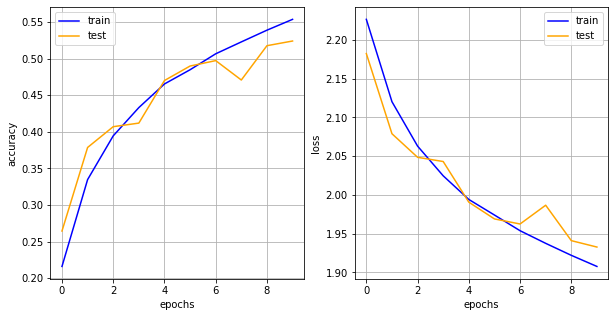

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)


#Interesting! Only by using the recommended initialization for ReLU, i.e., that of Kaiming He, I see this faster learning trend.

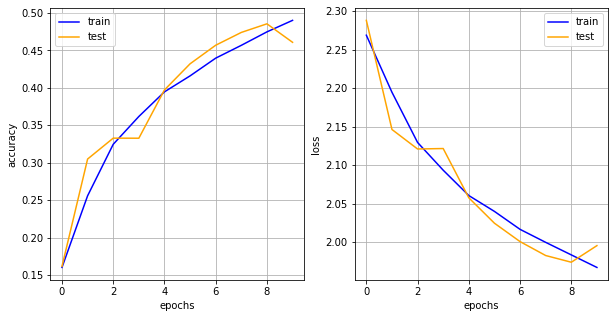

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

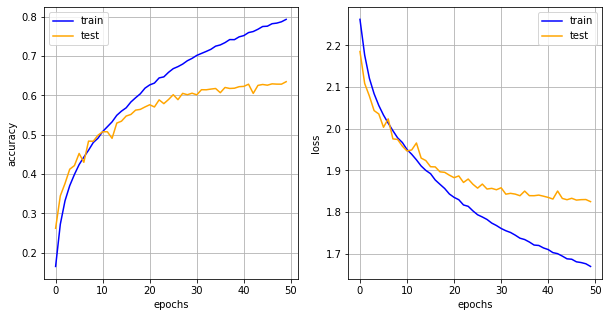

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

Seems overfitting has started. We try some regularization. But also, we use the good initialization, by Kaiming He.

In [10]:
#Alex
class Alex_regularized(nn.Module):
  def __init__(self, kernel_size, pool_size):
    super(Alex_regularized, self).__init__()
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.layer1 = nn.Sequential(nn.Conv2d(3,16,kernel_size,padding='same'), nn.ReLU())
    nn.init.kaiming_normal_(self.layer1[0].weight)
    self.layer2 = nn.Sequential(nn.Conv2d(16,64,kernel_size,padding='same'), nn.ReLU(), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer2[0].weight)

    self.layer3 = nn.Sequential(nn.Conv2d(64,128,kernel_size,padding='same'), nn.ReLU(), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer3[0].weight)

    self.out = nn.Linear(8*8*128, 10)
    nn.init.kaiming_normal_(self.out.weight)

    self.dropout1  = nn.Dropout(.2)
    self.dropout2  = nn.Dropout(.3)
    self.dropout3  = nn.Dropout(.5)
   # self.dropout_out = nn.Dropout(.3)

  def forward(self,x):
    x = self.layer1(x)
    x=self.dropout1(x)
    x = self.layer2(x)
    x=self.dropout2(x)    
    x = self.layer3(x)
    x=self.dropout3(x)

    x = x.view(-1,8*8*128)
    x = self.out(x)
    output = nn.functional.softmax(x)
    return output

In [ ]:
epochs = 100
alex_model_reg = Alex_regularized(5,2).to(device)
# alex_model = alex_model.to(device)
optimizer = optim.SGD(alex_model_reg.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(alex_model_reg, loss, optimizer, cifar_train_loader, cifar_valid_loader, epochs)

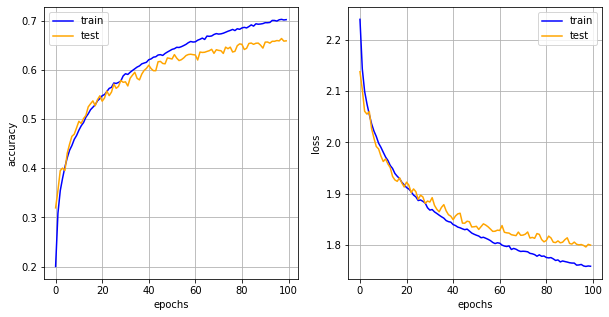

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

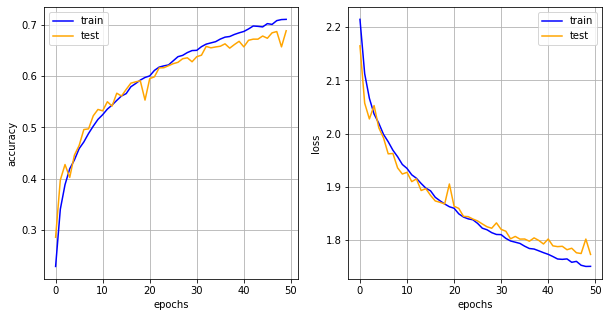

In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

##Let's try Adam optimizer! (Why it isn't working?)

In [11]:
epochs = 10
alex_model_reg = Alex_regularized(5,2).to(device)
# alex_model = alex_model.to(device)
optimizer = optim.Adam(alex_model_reg.parameters(), lr = .001)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(alex_model_reg, loss, optimizer, cifar_train_loader, cifar_valid_loader, epochs)

100%|██████████| 10/10 [02:42<00:00, 16.27s/it]


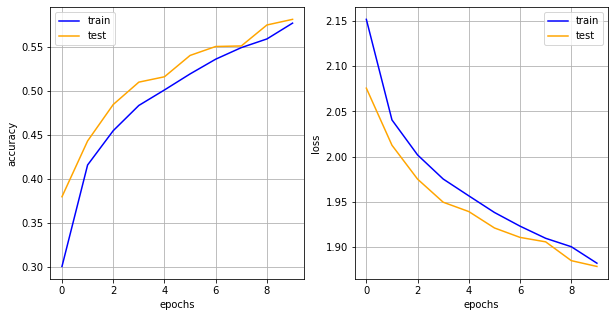

In [12]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

##and what if we add batch norm to Alex_regularized?

In [10]:
#Alex
class Alex_regularized_bn(nn.Module):
  def __init__(self, kernel_size, pool_size):
    super(Alex_regularized_bn, self).__init__()
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.layer1 = nn.Sequential(nn.Conv2d(3,16,kernel_size,padding='same'), nn.BatchNorm2d(16, momentum=.3), nn.ReLU())
    nn.init.kaiming_normal_(self.layer1[0].weight)
    self.layer2 = nn.Sequential(nn.Conv2d(16,64,kernel_size,padding='same'), nn.ReLU(),nn.BatchNorm2d(64, momentum = .3), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer2[0].weight)

    self.layer3 = nn.Sequential(nn.Conv2d(64,128,kernel_size,padding='same'), nn.ReLU(), nn.BatchNorm2d(128, momentum = .1), nn.AvgPool2d(pool_size))
    nn.init.kaiming_normal_(self.layer3[0].weight)

    self.out = nn.Linear(8*8*128, 10)
    nn.init.kaiming_normal_(self.out.weight)

    self.dropout1  = nn.Dropout(.2)
    self.dropout2  = nn.Dropout(.3)
    self.dropout3  = nn.Dropout(.4)
   # self.dropout_out = nn.Dropout(.3)

  def forward(self,x):
    x = self.layer1(x)
    #x=self.dropout1(x)
    x = self.layer2(x)
    #x=self.dropout2(x)    
    x = self.layer3(x)
    x=self.dropout3(x)

    x = x.view(-1,8*8*128)
    x = self.out(x)
    output = nn.functional.softmax(x)
    return output

In [ ]:
epochs = 50
alex_model_reg_bn = Alex_regularized_bn(5,2).to(device)
optimizer = optim.Adam(alex_model_reg_bn.parameters(), lr = .001)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(alex_model_reg_bn, loss, optimizer, cifar_train_loader, cifar_valid_loader, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

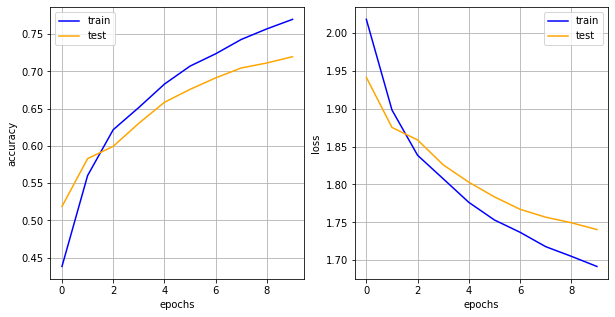

In [77]:
acc_list_train = [acc.cpu() for acc in acc_list_train]
acc_list_test = [acc.cpu() for acc in acc_list_test]
loss_list_train = [loss.cpu().detach() for loss in loss_list_train]
loss_list_test = [loss.cpu().detach() for loss in loss_list_test]

#Plot the results for LeNet!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

#Part4: Transfer Learning (VGG16 on CIFAR10)

#PART 3: Batch Nomalization

Batch normalization often yields faster training. Note that the operation is differentiable.

In [ ]:
#A mlp with three hidden layers of sizes 1000, 1500, 800 and with batch norm
class MLP(nn.Module):
  def __init__(self, hidden_1, hidden_2):#, hidden_3):
    super(MLP,self).__init__()

    self.hidden_1, self.hidden_2 = hidden_1, hidden_2
    self.normalized_data_1 = nn.BatchNorm1d(512) #Batch normalization is addded.
    self.normalized_data_2 = nn.BatchNorm1d(128) #Batch normalization is addded.
    self.fc1 = nn.Linear(784, self.hidden_1)
    self.fc2 = nn.Linear(self.hidden_1, self.hidden_2)
 #   self.fc3 = nn.Linear(self.hidden_2, self.hidden_3)
    self.out = nn.Linear(self.hidden_2, 10)

  def forward(self,x):
    activ_1 = F.relu(self.normalized_data_1(self.fc1(x)))
    activ_2 = F.relu(self.normalized_data_2(self.fc2(activ_1)))
   # activ_3 = F.relu(self.fc3(activ_2))
    output = F.softmax(self.out(activ_2))
    #output = self.out(activ_2)
    return output

In [ ]:
epochs = 10
mlp_model = MLP(512,128)
mlp_model = mlp_model.to(device)
optimizer = optim.SGD(mlp_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(mlp_model, loss, optimizer, mnist_train_loader, mnist_valid_loader, epochs, fully_connected = True)

100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


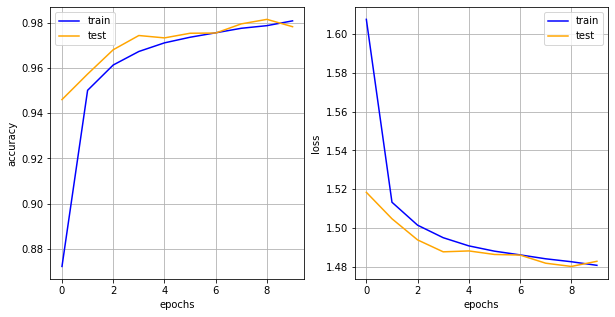

In [ ]:
#Plot the results for MLP with BN (batch norm)!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

In [ ]:
print("# Parameters: ", sum([param.nelement() for param in mlp_model.parameters()]))

# Parameters:  470154


In [ ]:
#LeNet5 with batch norm
class Lenet5(nn.Module):
  def __init__(self, kernel_size, pool_size):
    super(Lenet5, self).__init__()
#    self.normalize = nn.BatchNorm2d(1,)
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.layer1 = nn.Sequential(nn.Conv2d(1,16,5,padding='same'), nn.BatchNorm2d(16), nn.ReLU(), nn.AvgPool2d(2))
    self.layer2 = nn.Sequential(nn.Conv2d(16,32,5,padding='same'),nn.BatchNorm2d(32) , nn.ReLU(), nn.AvgPool2d(2))
    self.outlayer = nn.Linear(7*7*32, 10)

  def forward(self,x):
#    x = self.normalize(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1,7*7*32)
    x = self.outlayer(x)
    output = nn.functional.softmax(x)
    return output

*** I should check if the batchnorm has been applied to train and validation in the correct way.

In [ ]:
epochs = 10
lenet_model = Lenet5(3,2)
lenet_model = lenet_model.to(device)
optimizer = optim.SGD(lenet_model.parameters(), lr = .3)
loss = nn.CrossEntropyLoss()
acc_list_train, loss_list_train, acc_list_test, loss_list_test = train_nn(lenet_model, loss,optimizer, mnist_train_loader, mnist_valid_loader, epochs)

100%|██████████| 10/10 [01:23<00:00,  8.33s/it]


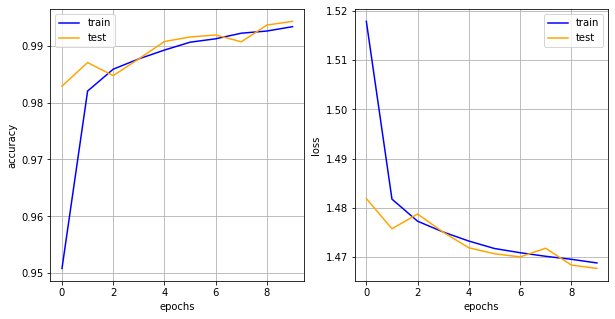

In [ ]:
#Plot the results for MLP with BN (batch norm)!
plot_results(acc_list_train, acc_list_test, loss_list_train, loss_list_test)

In [ ]:
print(lenet_model)

print("\n\n# Parameters: ", sum([param.nelement() for param in lenet_model.parameters()]))

Lenet5(
  (normalize): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (outlayer): Linear(in_features=1568, out_features=10, bias=True)
)


# Parameters:  28940


#PART 4: Transfer Learning : Finetuning the convnet vs. convnet as fixed feature extractor.


In [ ]:
from tqdm import tqdm
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch.optim as optim
import copy

For this part, we work with a small subset of IKmagenet: bees and ants.




In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2022-01-27 19:40:25--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.106, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.2’

hymenoptera_data.zi 100%[===================>]  45.10M   290MB/s    in 0.2s    

2022-01-27 19:40:25 (290 MB/s) - ‘hymenoptera_data.zip.2’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

In [ ]:
data_dir = 'hymenoptera_data'

In [ ]:
data_transforms = {
    # Data augmentation and normalization for training
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Data normalization for validation
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder('/'.join([data_dir, x]),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [ ]:
batch_size= 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

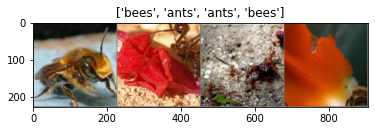

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
my_resnet = models.resnet18(pretrained=True)
my_resnet.fc = nn.Linear(my_resnet.fc.in_features ,2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
[a.nelement() for a in my_resnet.fc.parameters()]

[1024, 2]

In [ ]:
my_resnet.state_dict()['fc.weight']

tensor([[ 0.0218, -0.0220,  0.0394,  ...,  0.0229, -0.0229, -0.0158],
        [-0.0045,  0.0104, -0.0213,  ..., -0.0267,  0.0370, -0.0245]])

In [ ]:
#finetunning the resnet18 pretrained model.
def train_model(dataloaders, model, loss, optimizer, epochs):
  #model_to_return = model
  highest_acc = 0
  iter =0 
  for e in tqdm(range(epochs)):
    iter += 1
    print(f'\nepoch {e+1}/{epochs}')
    for mode in ['train', 'val']:
      if mode == 'train':
        model.train()
      else:
        model.eval()
      model_loss = 0
      model_acc = 0
      model = model.to(device)
      for data,labels in dataloaders[mode]:
        data = data.to(device)
        labels = labels.to(device)
        model_output = model(data)
        _,model_predict = torch.max(model_output,1)
        batch_acc = torch.sum((model_predict == labels).float())/batch_size
        if mode == 'train':
          with torch.set_grad_enabled(True):
            batch_loss = loss(model_output, labels)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        else:
          batch_loss = loss(model_output, labels)
        model_loss += batch_loss.item()/len(dataloaders[mode])
        model_acc += batch_acc/len(dataloaders[mode])
      print('\n{} loss = {}, {} accuracy = {}'.format(mode, model_loss, mode, model_acc))
    if model_acc>highest_acc:#Based on the best validation accuracy, we save the model parameters at that best point.
      highest_acc = model_acc
      best_model_weights, index = copy.deepcopy(model.state_dict()), iter
    print('--'*10)
  model.load_state_dict(best_model_weights)
  return (model,index) 


In [ ]:
epochs = 9
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_resnet.parameters(), lr = .0001)
final_model,epoch_index = train_model(dataloaders, my_resnet, loss, optimizer, epochs)

  0%|          | 0/9 [00:00<?, ?it/s]


epoch 1/9

train loss = 0.572901232809317, train accuracy = 0.7663930654525757


 11%|█         | 1/9 [00:03<00:29,  3.63s/it]


val loss = 0.4999975638511853, val accuracy = 0.7628207206726074
--------------------

epoch 2/9

train loss = 0.5720395499565563, train accuracy = 0.7131143808364868


 22%|██▏       | 2/9 [00:07<00:25,  3.61s/it]


val loss = 0.4919747679661481, val accuracy = 0.7820514440536499
--------------------

epoch 3/9

train loss = 0.555002685453071, train accuracy = 0.7418029308319092


 33%|███▎      | 3/9 [00:11<00:22,  3.70s/it]


val loss = 0.47990789398168915, val accuracy = 0.7948719263076782
--------------------

epoch 4/9

train loss = 0.5571296171086733, train accuracy = 0.721311092376709


 44%|████▍     | 4/9 [00:14<00:18,  3.72s/it]


val loss = 0.45540914474389504, val accuracy = 0.8269231915473938
--------------------

epoch 5/9

train loss = 0.5412202013320611, train accuracy = 0.7459012866020203


 56%|█████▌    | 5/9 [00:18<00:14,  3.73s/it]


val loss = 0.44056143668981695, val accuracy = 0.8205130696296692
--------------------

epoch 6/9

train loss = 0.53707662664476, train accuracy = 0.7295078039169312


 67%|██████▋   | 6/9 [00:22<00:11,  3.74s/it]


val loss = 0.43382992843786894, val accuracy = 0.8269232511520386
--------------------

epoch 7/9

train loss = 0.527151420712471, train accuracy = 0.78278648853302


 78%|███████▊  | 7/9 [00:26<00:07,  3.74s/it]


val loss = 0.41142721130297727, val accuracy = 0.8525640964508057
--------------------

epoch 8/9

train loss = 0.5428432670773051, train accuracy = 0.7377044558525085


 89%|████████▉ | 8/9 [00:29<00:03,  3.74s/it]


val loss = 0.4200981343403842, val accuracy = 0.8269231915473938
--------------------

epoch 9/9

train loss = 0.48561211296769446, train accuracy = 0.8155733346939087


100%|██████████| 9/9 [00:33<00:00,  3.74s/it]


val loss = 0.3952563771834739, val accuracy = 0.8653847575187683
--------------------


In [ ]:
epoch_index

9

In [ ]:
#Now, we save the best model parameters, using state_dict method.
torch.save(final_model.state_dict(), 'best_model')

In [ ]:
#Next, we load the saved model and evaluate it on the validation data.
my_resnet = models.resnet18()
in_feat = my_resnet.fc.in_features
my_resnet.fc = nn.Linear(in_feat,2)
my_resnet.load_state_dict(torch.load('best_model'))
my_resnet = my_resnet.to(device)
my_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
acc = 0
for data , label in dataloaders['val']:
  data = data.to(device)
  label = label.to(device)
  res = my_resnet(data)
  _,pred = torch.max(res,1)
  acc_batch = torch.sum((pred == label).float())/4
  acc += acc_batch/len(dataloaders['val'])

In [ ]:
acc

tensor(0.8654, device='cuda:0')

The alternative approach to transfer learning is to use the pretrained Rennet18 as a fixed feature extractor and just fine-tune the fc layer.